Importing modules

In [23]:
import math
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas_datareader as web
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM


Reading the Data

In [38]:
# csv link - https://www.kaggle.com/datasets/henryshan/coca-cola-stock-price/

df = pd.read_csv('KO.csv', skiprows=lambda x : x in range(1,10000) );
df['Date'] = pd.to_datetime(df['Date'])
df


,Date,Open,High,Low,Close,Adj Close,Volume
0,2001-09-21,23.000000,23.915001,22.625000,23.400000,12.373243,23054200
1,2001-09-24,23.405001,24.350000,23.405001,24.014999,12.698437,13608400
2,2001-09-25,23.924999,24.629999,23.905001,24.000000,12.690507,17787200
3,2001-09-26,23.950001,24.000000,23.379999,23.445000,12.397036,11593800
4,2001-09-27,23.490000,23.535000,23.250000,23.475000,12.412901,11084800
...,...,...,...,...,...,...,...
5585,2023-11-29,58.580002,58.669998,58.099998,58.230000,57.770000,11263600
5586,2023-11-30,57.959999,58.459999,57.599998,58.439999,58.439999,22727500
5587,2023-12-01,58.270000,58.689999,58.240002,58.639999,58.639999,15369600
5588,2023-12-04,58.590000,58.959999,58.439999,58.570000,58.570000,14942200


Visualizing the data

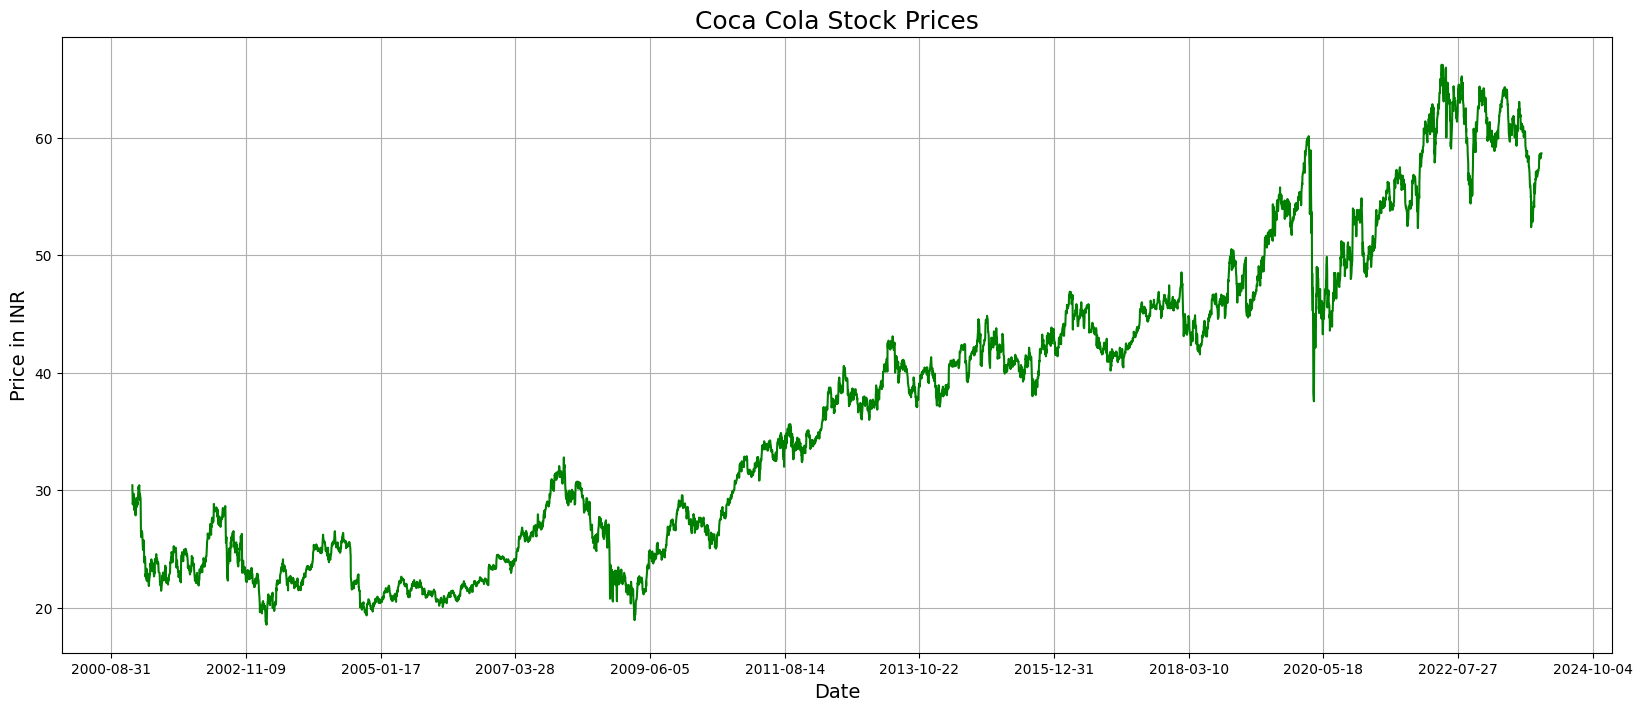

In [37]:
name = "Coca Cola"

fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(df['Date'], df['Close'], color='green')
ax.xaxis.set_major_locator(plt.MaxNLocator(15))
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Price in INR', fontsize=14)
plt.title(f'{name} Stock Prices', fontsize=18)
plt.grid()
plt.show()

Dividing data into training part and prediction part

In [39]:
sub_data = df.filter(['Close'])
dataset = sub_data.values
training_data_len = math.ceil( len(dataset) * .8 )
training_data_len

4472

Data preprocessing

In [40]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.1020451 ],
       [0.11494492],
       [0.11463031],
       ...,
       [0.84121657],
       [0.83974831],
       [0.8416361 ]])

Extracting train data and transforming it to fit our model

In [41]:
train_data = scaled_data[0:training_data_len,:]
x_train = []
y_train = []

for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i, 0])

In [42]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [43]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1) )

In [44]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [45]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [46]:
model.fit(x_train, y_train, batch_size=1, epochs=1)

4412/4412 [==============================] - 178s 39ms/step - loss: 4.8412e-04


Data prediction on rest of the dataframe

In [47]:
test_data = scaled_data [training_data_len-60 : , :]
x_test = []
y_test = dataset[training_data_len: , : ]
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])


In [48]:
x_test = np.array(x_test)

In [49]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1) )

In [50]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)


35/35 [==============================] - 1s 14ms/step


Plotting the actual and predicted data to evaluate correctness

<ipython-input-54-2b5db35af471>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


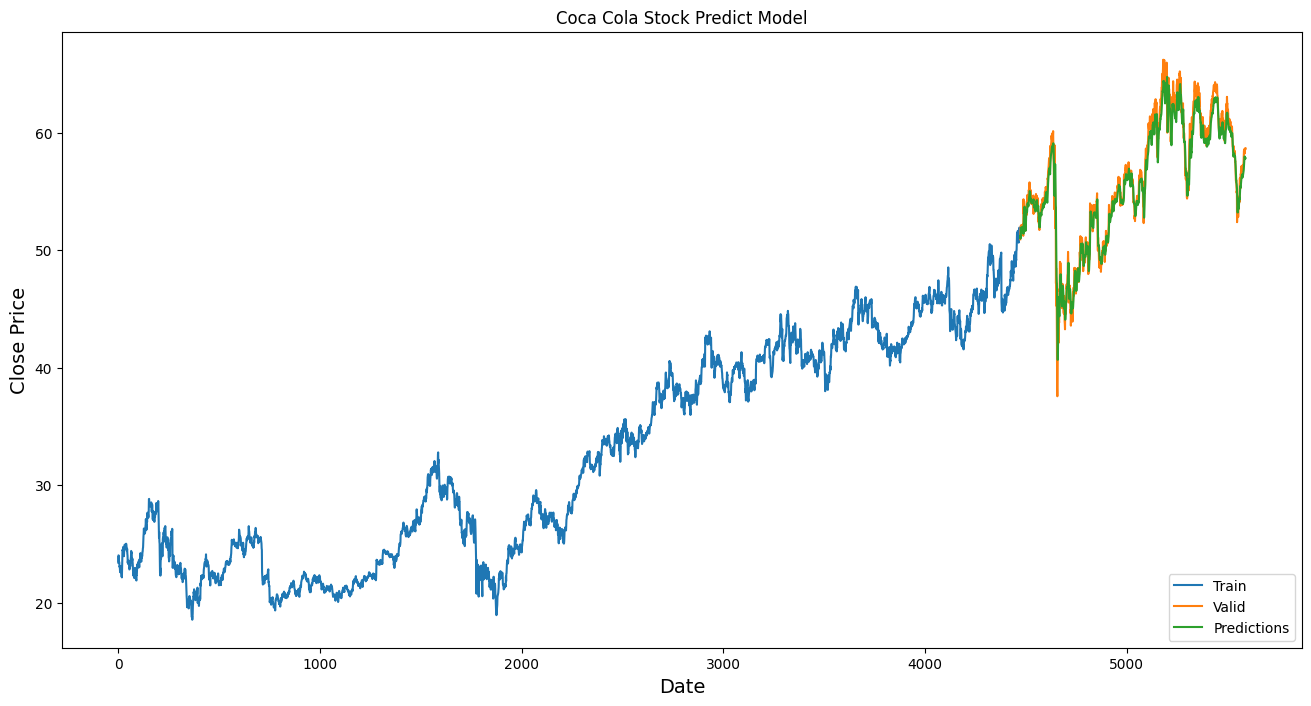

In [54]:
train = sub_data[:training_data_len]
valid = sub_data[training_data_len:]
valid['Predictions'] = predictions
plt.figure( figsize=(16,8) )
plt.title('Coca Cola Stock Predict Model')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price', fontsize=14)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Valid', 'Predictions'], loc='lower right')
plt.show()